<a href="https://colab.research.google.com/github/badamosor/csci-5922/blob/master/arabic_seq2seq_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import nltk
nltk.download('punkt')


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        
    def addSentence(self, sentence):
        #print("input:", sentence)
        tokenized_text = nltk.word_tokenize(sentence)

        #print("tokenized:", tokenized_text)
        for word in tokenized_text:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
import codecs
import csv
import random
from sklearn.model_selection import train_test_split

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")   

    #FILENAME = "arabic_words.csv"
    FILENAME_TRAIN = "trainig_data_3000.csv"
    FILENAME_TEST = "test_data_3000_425.csv"
    

    ENCODING = 'utf-8'
    train_pairs = []
    with codecs.open(FILENAME_TRAIN, "r", ENCODING) as fp:
      reader = csv.reader(fp)
      for rows in reader:
        train_pairs.append(rows)
        
    test_pairs = []
    with codecs.open(FILENAME_TEST, "r", ENCODING) as fp:
      reader = csv.reader(fp)
      for rows in reader:
        test_pairs.append(rows)
      
        
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    #Split into train and test
   
    #pairs = pairs[0:100]
    #train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
    
    return input_lang, output_lang, train_pairs, test_pairs


        

In [14]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, test_pairs = readLangs(lang1, lang2, reverse)
  
    print("Read %s training sentence pairs" % len(train_pairs))
  
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in train_pairs:
        #print("printing pairs:", pair[0], pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    ##!!!Adding new words in test to training words
    
    print("Read %s test sentence pairs" % len(test_pairs))
    print("Counting words...")
    for pair in test_pairs:
        #print("printing pairs:", pair[0], pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, train_pairs, test_pairs


input_lang, output_lang, train_pairs, test_pairs = prepareData('NoDiac', 'Diac', False)
print(random.choice(train_pairs))
print(random.choice(test_pairs))



Reading lines...
Read 3002 training sentence pairs
Counting words...
Counted words:
NoDiac 6576
Diac 8264
Read 426 test sentence pairs
Counting words...
Counted words:
NoDiac 6576
Diac 8322
['لركبان شن والعمور وأضجما', 'لِرُكْبانِ شَنٍّ والعُمُورِ وأَضْجَما']
['وأنه ضرب من الأسماء', 'وأَنه ضَرْبٌ من الأَسماء']


In [15]:
print([input_lang.word2index])
print([output_lang.word2index])


[{'no_diacritics': 2, 'كلمات': 3, 'أو': 4, 'تعابير': 5, 'مطابقة': 6, 'خلاف': 7, 'العجم': 8, 'وهما': 9, 'واحد': 10, 'عبدالمؤمن': 11, 'ابن': 12, 'عبدالقدوس': 13, 'فأما': 14, 'البهط': 15, 'وحيتانكم': 16, 'فما': 17, 'زلت': 18, 'فلم': 19, 'أر': 20, 'فيها': 21, 'كضب': 22, 'كبيض': 23, 'الدجاج': 24, 'وبيض': 25, 'الجراد': 26, 'شفاء': 27, 'القرم': 28, 'ومكن': 29, 'الضباب': 30, 'طعام': 31, 'العريـ': 32, 'ـب': 33, 'لا': 34, 'تشتهيه': 35, 'نفوس': 36, 'صغرهم': 37, 'جذيلها': 38, 'المحكك': 39, 'وعذيقها': 40, 'المرجب': 41, 'والعرب': 42, 'العاربة': 43, 'هم': 44, 'الخلص': 45, 'لائل': 46, 'تقول': 47, 'عرب': 48, 'عاربة': 49, 'وعرباء': 50, 'صرحاء': 51, 'ومتعربة': 52, 'ومستعربة': 53, 'الأعراب': 54, 'آمنا': 55, 'قل': 56, 'لم': 57, 'تؤمنوا': 58, 'ولكن': 59, 'قولوا': 60, 'أسلمنا': 61, 'أشد': 62, 'كفرا': 63, 'ونفاقا': 64, 'العذب': 65, 'من': 66, 'الشراب': 67, 'والطعام': 68, 'وتقي': 69, 'ساكت': 70, 'عنه': 71, 'للتقية': 72, 'عربي': 73, 'وفرس': 74, 'معرب': 75, 'خلصت': 76, 'عربيته': 77, 'وعرب': 78, 'الفرس': 79, 'بزغه

In [0]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
MAX_LENGTH = 10
loss_per_iter = []
avg_loss_per_iter = []
sent_accur = []
word_accur = []

In [0]:
def indexesFromSentence(lang, sentence):
      return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    #print("Pair is:",pair[0],pair[1])
    #print("Tensors:",input_tensor, target_tensor)
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print("input_length",input_length,"target_length:",target_length)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #print(encoder_outputs.shape)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, save_every_iters= 10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs))
     #                 for i in range(n_iters)]
    #training_pairs = [tensorsFromPair(random.choice(train_pairs))
                    #  for i in range(n_iters)]
    
    criterion = nn.NLLLoss()
        
    for i in range(n_iters):
      
      numExample = 0
      for pairs in train_pairs:
          training_pair = tensorsFromPair(pairs)
          input_tensor = training_pair[0]
          target_tensor = training_pair[1]

          loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
          print_loss_total += loss
          plot_loss_total += loss

#        if iter % print_every == 0:
          numExample += 1
          if (numExample % print_every == 0):       
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
            #print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         #iter, iter / n_iters * 100, print_loss_avg))
              print('%s %d %.4f' % (timeSince(start, numExample), numExample, print_loss_avg))
              
      print(('%.4f,%.4f') % ((print_loss_total / print_every),loss))
      
      
      loss_per_iter.append(loss)
      avg_loss_per_iter.append(print_loss_total / print_every)
          
      """
      if ((i % 5) == 0): 
          
        model_save_name = 'encoder.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(encoder.state_dict(), path)

        model_save_name = 'decoder.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(decoder.state_dict(), path)
      """
            
#         if iter % plot_every == 0:
#             plot_loss_avg = plot_loss_total / plot_every
#             plot_losses.append(plot_loss_avg)
#             plot_loss_total = 0

#     #print ("got here")
#     showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
           # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
           # decoder_attentions[di] = decoder_attention.data
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                #if (topi.item() not in output_lang.test_index2word):
                  #decoded_words.append("unk")
                #else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        #return decoded_words, decoder_attentions[:di + 1]
        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    correct_word_pair = 0
    incorrect_word_pair = 0
    
    correct_sentence_pair = 0
    incorrect_sentence_pair = 0
    
    for pair in test_pairs:
      
        #pair = random.choice(pairs)
        #pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        #output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        #Accuracy on sentence basis
        if (pair[1] == output_sentence):
            correct_sentence_pair += 1
        else:
            incorrect_sentence_pair += 1
            
        #Accuracy on word basis
        tokenized_target = nltk.word_tokenize(pair[1])
        
        for target, output in zip(tokenized_target, output_words):
          if (target == output):
            correct_word_pair += 1
          else:
            incorrect_word_pair += 1
            print("Incorrect word pair:")
            print(target, output)
                
    print("accuracy of sentences:",correct_sentence_pair/(correct_sentence_pair+incorrect_sentence_pair),correct_sentence_pair,incorrect_sentence_pair) 
    print("accuracy of words:",correct_word_pair/(correct_word_pair+incorrect_word_pair),correct_word_pair,incorrect_sentence_pair) 
    sent_accur.append(correct_sentence_pair/(correct_sentence_pair+incorrect_sentence_pair)) 
    word_accur.append(correct_word_pair/(correct_word_pair+incorrect_word_pair))


In [26]:
print("input:", input_lang.n_words)
print("train size", len(train_pairs))

input: 6576
train size 3002


In [0]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)


In [0]:

model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
encoder1.load_state_dict(torch.load(path))
model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
decoder1.load_state_dict(torch.load(path))


In [33]:
trainIters(encoder1, decoder1, 10, print_every=1000)


2m 15s (- -3m 44s) 1000 5.5206
4m 54s (- -5m 5s) 2000 6.9163
7m 40s (- -8m 19s) 3000 6.8979
0.0136,6.6060
10m 27s (- -11m 33s) 1000 6.6766
13m 17s (- -14m 42s) 2000 6.5665
16m 14s (- -17m 45s) 3000 6.4101
0.0127,6.1141
19m 9s (- -20m 51s) 1000 6.2267
22m 1s (- -23m 59s) 2000 6.1025
24m 58s (- -25m 2s) 3000 5.9107
0.0118,5.7291
27m 53s (- -28m 7s) 1000 5.7062
30m 50s (- -31m 10s) 2000 5.5709
33m 45s (- -34m 15s) 3000 5.3532
0.0108,5.1376
36m 42s (- -37m 19s) 1000 5.1452
39m 37s (- -40m 23s) 2000 4.9975
42m 34s (- -43m 26s) 3000 4.7523
0.0094,4.3967
45m 34s (- -46m 28s) 1000 4.5442
48m 32s (- -49m 29s) 2000 4.3794
51m 30s (- -52m 30s) 3000 4.1325
0.0081,3.7398
54m 27s (- -55m 35s) 1000 3.9200
57m 25s (- -58m 36s) 2000 3.7455
60m 24s (- -61m 36s) 3000 3.5033
0.0070,3.1708
63m 23s (- -64m 40s) 1000 3.2884
66m 10s (- -67m 51s) 2000 3.1091
68m 12s (- -69m 49s) 3000 2.8776
0.0057,2.5334
70m 8s (- -71m 55s) 1000 2.6755
72m 6s (- -73m 55s) 2000 2.4953
73m 59s (- -74m 1s) 3000 2.2762
0.0045,1.95

In [0]:
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)

In [39]:
evaluateRandomly(encoder1, decoder1)

> no_diacritics
= with_diacritics
< with_diacritics الإِبل الإِبل

> الخطابي أن حبة العرني
= الخطابي أَن حَبَّةَ العُرَنيَّ
< الخطابي أَن حَبَّةَ العُرَنيَّ

> أرض في أنه مؤنث
= أَرض في أَنه مؤَنث
< في في في الكِنْدِين

Incorrect word pair:
أَرض في
Incorrect word pair:
أَنه في
Incorrect word pair:
مؤَنث الكِنْدِين
> على أحر كأنه أراد
= على أَحَرَّ كأَنه أَراد
< على على أَراد أَراد

Incorrect word pair:
أَحَرَّ على
Incorrect word pair:
كأَنه أَراد
> حر العبد يحر حرارة
= حَرَّ العبدُ يَحَرُّ حَرارَةً
< حَرَّ حَرَّ حَرَّةً وحَراراً

Incorrect word pair:
العبدُ حَرَّ
Incorrect word pair:
يَحَرُّ حَرَّةً
Incorrect word pair:
حَرارَةً وحَراراً
> إلى أهله أي صاحبه
= إِلى أَهله أَي صاحبه
< حتى إِلى أَي إِلى

Incorrect word pair:
إِلى حتى
Incorrect word pair:
أَهله إِلى
Incorrect word pair:
صاحبه إِلى
> عليها كل بكر حرة
= عليها كُلُّ بِكْرٍ حُرَّةٍ
< وحَرَّ وحَرَّ حَرَّةً حَرَّةً

Incorrect word pair:
عليها وحَرَّ
Incorrect word pair:
كُلُّ وحَرَّ
Incorrect word pair:
بِكْرٍ حَرَّةً
Incorrect w

In [40]:
trainIters(encoder1, decoder1, 10, print_every=1000, learning_rate = 0.001)
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)
evaluateRandomly(encoder1, decoder1)

3m 1s (- -4m 58s) 1000 1.9246
6m 0s (- -7m 59s) 2000 1.6846
9m 1s (- -10m 58s) 3000 1.3946
0.0026,1.0313
12m 2s (- -13m 58s) 1000 1.7764
15m 6s (- -16m 53s) 2000 1.5830
18m 10s (- -19m 49s) 3000 1.3668
0.0026,0.9959
21m 14s (- -22m 46s) 1000 1.6903
24m 19s (- -25m 40s) 2000 1.5195
27m 51s (- -28m 9s) 3000 1.3246
0.0026,1.0023
31m 34s (- -32m 27s) 1000 1.6253
35m 14s (- -36m 46s) 2000 1.4665
38m 53s (- -39m 7s) 3000 1.2813
0.0024,1.0321
42m 36s (- -43m 26s) 1000 1.5656
46m 20s (- -47m 41s) 2000 1.4172
50m 8s (- -51m 52s) 3000 1.2376
0.0024,1.0023
53m 53s (- -54m 9s) 1000 1.5116
57m 46s (- -58m 14s) 2000 1.3708
61m 36s (- -62m 24s) 3000 1.1974
0.0023,0.9684
65m 19s (- -66m 44s) 1000 1.4601
68m 35s (- -69m 26s) 2000 1.3202
71m 33s (- -72m 28s) 3000 1.1590
0.0022,0.9465
74m 33s (- -75m 31s) 1000 1.4089
77m 33s (- -78m 28s) 2000 1.2709
80m 33s (- -81m 27s) 3000 1.1242
0.0021,0.9281
83m 34s (- -84m 30s) 1000 1.3610
86m 36s (- -87m 26s) 2000 1.2237
89m 37s (- -90m 24s) 3000 1.0896
0.0021,0.91

In [62]:
trainIters(encoder1, decoder1, 10, print_every=1000, learning_rate = 0.001)
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)
evaluateRandomly(encoder1, decoder1)

2m 2s (- -3m 57s) 1000 1.2669
4m 26s (- -5m 34s) 2000 1.1379
7m 22s (- -8m 37s) 3000 1.0226
0.0020,0.8742
10m 19s (- -11m 41s) 1000 1.2231
13m 13s (- -14m 47s) 2000 1.0951
16m 8s (- -17m 51s) 3000 0.9906
0.0019,0.8450
19m 3s (- -20m 58s) 1000 1.1782
21m 57s (- -22m 2s) 2000 1.0566
24m 54s (- -25m 5s) 3000 0.9580
0.0018,0.8210
27m 51s (- -28m 10s) 1000 1.1389
30m 47s (- -31m 13s) 2000 1.0194
33m 42s (- -34m 18s) 3000 0.9269
0.0019,0.8021
36m 40s (- -37m 21s) 1000 1.0946
39m 36s (- -40m 25s) 2000 0.9835
42m 31s (- -43m 29s) 3000 0.8967
0.0018,0.7803
45m 28s (- -46m 34s) 1000 1.0559
48m 23s (- -49m 38s) 2000 0.9490
51m 18s (- -52m 42s) 3000 0.8675
0.0017,0.7588
54m 20s (- -55m 43s) 1000 1.0220
57m 17s (- -58m 44s) 2000 0.9149
60m 11s (- -61m 49s) 3000 0.8385
0.0016,0.7379
63m 8s (- -64m 55s) 1000 0.9816
66m 4s (- -67m 57s) 2000 0.8838
68m 58s (- -69m 2s) 3000 0.8113
0.0016,0.7165
71m 54s (- -72m 9s) 1000 0.9495
74m 51s (- -75m 11s) 2000 0.8538
77m 50s (- -78m 11s) 3000 0.7845
0.0015,0.695

In [29]:
trainIters(encoder1, decoder1, 10, print_every=1000, learning_rate = 0.001)
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)
evaluateRandomly(encoder1, decoder1)

3m 5s (- -4m 54s) 1000 0.8753
6m 20s (- -7m 39s) 2000 0.7970
9m 36s (- -10m 23s) 3000 0.7350
0.0014,0.6565
12m 53s (- -13m 7s) 1000 0.8488
16m 8s (- -17m 52s) 2000 0.7710
19m 24s (- -20m 36s) 3000 0.7123
0.0014,0.6387
22m 41s (- -23m 20s) 1000 0.8148
25m 57s (- -26m 3s) 2000 0.7455
29m 14s (- -30m 46s) 3000 0.6897
0.0013,0.6210
32m 31s (- -33m 30s) 1000 0.7906
35m 48s (- -36m 12s) 2000 0.7220
39m 7s (- -40m 53s) 3000 0.6680
0.0013,0.6030
42m 25s (- -43m 36s) 1000 0.7588
45m 45s (- -46m 15s) 2000 0.6983
49m 4s (- -50m 56s) 3000 0.6461
0.0012,0.5859
52m 24s (- -53m 39s) 1000 0.7360
55m 41s (- -56m 20s) 2000 0.6755
59m 0s (- -59m 0s) 3000 0.6254
0.0012,0.5701
62m 16s (- -63m 47s) 1000 0.7072
65m 31s (- -66m 30s) 2000 0.6526
68m 47s (- -69m 13s) 3000 0.6052
0.0012,0.5548
72m 4s (- -73m 59s) 1000 0.6871
75m 21s (- -76m 41s) 2000 0.6312
78m 37s (- -79m 24s) 3000 0.5861
0.0011,0.5399
81m 54s (- -82m 10s) 1000 0.6643
85m 12s (- -86m 49s) 2000 0.6109
88m 30s (- -89m 30s) 3000 0.5680
0.0011,0.52

In [30]:
trainIters(encoder1, decoder1, 10, print_every=1000, learning_rate = 0.001)
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)
evaluateRandomly(encoder1, decoder1)

3m 15s (- -4m 44s) 1000 0.6201
6m 31s (- -7m 28s) 2000 0.5738
9m 52s (- -10m 7s) 3000 0.5335
0.0010,0.4927
13m 17s (- -14m 43s) 1000 0.6029
16m 42s (- -17m 17s) 2000 0.5556
20m 7s (- -21m 53s) 3000 0.5177
0.0010,0.4754
23m 28s (- -24m 33s) 1000 0.5838
26m 51s (- -27m 9s) 2000 0.5389
30m 15s (- -31m 45s) 3000 0.5021
0.0010,0.4590
33m 37s (- -34m 24s) 1000 0.5655
37m 0s (- -37m 0s) 2000 0.5229
40m 21s (- -41m 39s) 3000 0.4876
0.0009,0.4440
43m 43s (- -44m 19s) 1000 0.5453
47m 8s (- -48m 53s) 2000 0.5074
50m 34s (- -51m 26s) 3000 0.4738
0.0009,0.4299
53m 58s (- -54m 4s) 1000 0.5320
57m 23s (- -58m 38s) 2000 0.4925
60m 46s (- -61m 14s) 3000 0.4604
0.0009,0.4171
64m 9s (- -65m 54s) 1000 0.5164
67m 33s (- -68m 28s) 2000 0.4781
70m 57s (- -71m 4s) 3000 0.4476
0.0008,0.4060
74m 21s (- -75m 42s) 1000 0.5011
77m 46s (- -78m 16s) 2000 0.4643
81m 9s (- -82m 52s) 3000 0.4352
0.0008,0.3987
84m 34s (- -85m 30s) 1000 0.4868
87m 59s (- -88m 3s) 2000 0.4513
91m 23s (- -92m 38s) 3000 0.4233
0.0008,0.3903

In [0]:
trainIters(encoder1, decoder1, 10, print_every=1000, learning_rate = 0.001)
model_save_name = 'encoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(decoder1.state_dict(), path)
evaluateRandomly(encoder1, decoder1)

3m 22s (- -4m 38s) 1000 0.4595
6m 44s (- -7m 15s) 2000 0.4268
10m 6s (- -11m 53s) 3000 0.4010
0.0008,0.3736
13m 29s (- -14m 31s) 1000 0.4476
16m 49s (- -17m 10s) 2000 0.4150


50


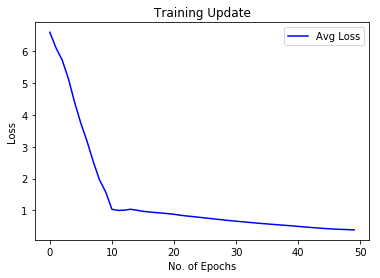

In [10]:
loss_true_per_epoch = [0.0136,0.0127,0.0118,0.0108,0.0094,0.0081,0.0070,0.0057,0.0045,0.0036,0.0026,0.0026,0.0026,0.0024,0.0024,0.0023,0.0022,0.0021,0.0021,0.002,0.002,0.0019,0.0018,0.0019,0.0018,0.0017,0.0016,0.0016,0.0015,
                       0.0015,0.0014,0.0014,0.0013,0.0013,0.0012,0.0012,0.0012,0.0011,0.0011,0.0011,0.0010,0.0010,0.0010,0.0009,0.0009,0.0009,0.008,0.008,0.008,0.008]
loss_avg_per_epoch = [6.6060,6.1141,5.7291,5.1376,4.3967,3.7398,3.1708,2.5334,1.9576,1.5762,1.0313,0.9959,1.0023,1.0321,1.0023,0.9684,0.9465,0.9281,0.9136,0.8946,0.8742,0.8450,0.8210,0.8021,0.7803,0.7588,0.7379,0.7165,0.6956,
                      0.6747,0.6565,0.6387,0.6210,0.6030,0.5859,0.5701,0.5548,0.5399,0.5248,0.5094,0.4927,0.4754,0.4590,0.4440,0.4299,0.4171,0.4060,0.3987,0.3903,0.3819]


iter = list(range(0,50))
print (len(loss_avg_per_epoch))
import pylab
#pylab.plot(iter, loss_true_per_epoch, '-y', label='True Loss')   
pylab.plot(iter, loss_avg_per_epoch, '-b', label='Avg Loss')
pylab.legend(loc='upper right')
pylab.title("Training Update")  
pylab.ylabel('Loss')
pylab.xlabel('No. of Epochs')
pylab.show()

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [0]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")